### Data Balancing

In [231]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
import scipy as sp
from io import StringIO
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

In [63]:
data = pd.read_csv('tornadoes-multiclass.csv')

In [64]:
X = preprocessing.scale(data.drop(['multiclass_casualties'],axis = 1))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [65]:
Y = data['multiclass_casualties']

In [185]:
#### Use Stratify = Y

# How stratify works This stratify parameter makes a split
# so that the proportion of values in the sample produced 
# will be the same as the proportion of values provided to parameter stratify.
# For example, if variable y is a binary categorical variable with values 0 and 1
# and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split
# has 25% of 0's and 75% of 1's.

# apply SMOTE only to training set, test set does not have to be balanced
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
sm = SMOTE(sampling_strategy='not majority')

In [186]:
x_train_balanced, y_train_balanced = sm.fit_resample(x_train, y_train)

### Decision Tree MultiClass Classifier

### Decision Tree Hyperparameter Tuning

### Default Parameters

In [187]:
default_parameters = DecisionTreeClassifier().fit(x_train_balanced, y_train_balanced)
y_pred = default_parameters.predict(x_test)

Confusion Matrix

In [188]:
array = confusion_matrix(y_test, y_pred)

In [189]:
[array[i]/sum(array[i]) for i in range(len(array))]

[array([0.90007402, 0.08882309, 0.01110289]),
 array([0.59090909, 0.34343434, 0.06565657]),
 array([0.18518519, 0.44444444, 0.37037037])]

F1 Score

In [190]:
f1_score(y_test, y_pred, average = 'macro')

0.4793222772674827

### Tuning split and leaf without cross-validation

In [154]:
min_samples_split_values = list(range(2,200,20))
min_samples_leaf_values = list(range(1,100,10))

In [160]:
plotting_data = []
for i in min_samples_split_values:
    for j in min_samples_leaf_values:
        dt = DecisionTreeClassifier(min_samples_split = i,min_samples_leaf=j).fit(x_train_balanced, y_train_balanced)
        y_pred = dt.predict(x_test)
        row = [i ,j, f1_score(y_test, y_pred, average = 'macro')]
        plotting_data.append(row)

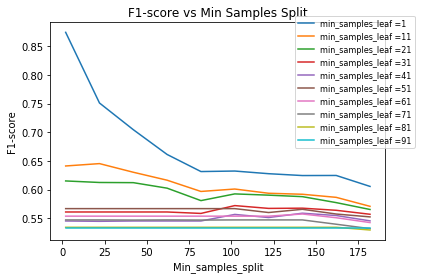

<Figure size 1080x576 with 0 Axes>

In [161]:
plotting = pd.DataFrame(plotting_data)
for i in min_samples_leaf_values:
    plt.plot(plotting[0][plotting[1] == i], plotting[2][plotting[1] == i], label = "min_samples_leaf =" + str(i))
plt.legend(prop={'size': 8}, bbox_to_anchor=(1.1, 1.05))
plt.title("F1-score vs Min Samples Split")
plt.ylabel("F1-score")
plt.xlabel("Min_samples_split")
plt.figure(figsize=(15,8))
plt.show()

In [162]:
plotting = plotting.rename(columns={ 0: 'Min_Samples_Split', 1: 'Min_Samples_Leaf', 2: 'f1_score'})

In [164]:
plotting[plotting['f1_score'] == plotting['f1_score'].max()]

,Min_Samples_Split,Min_Samples_Leaf,f1_score
0,2,1,0.874126


### Most important features are tornado_intensity', 'tornado_area' and  'minimum_range', followed by 'duration'.

### Tuning split and leaf with cross-validation

In [ ]:
k = 5
plotting_data2 = []
kf = KFold(n_splits=k)    
for train_index, test_index in kf.split(x_train_balanced):
    X_cv_train, X_cv_validate = pd.DataFrame(x_train_balanced).iloc[train_index], pd.DataFrame(x_train_balanced).iloc[test_index]
    Y_cv_train, Y_cv_validate = pd.DataFrame(y_train_balanced).iloc[train_index], pd.DataFrame(y_train_balanced).iloc[test_index]
    for i in min_samples_split_values:
        for j in min_samples_leaf_values:
            dt = DecisionTreeClassifier(min_samples_split = i, min_samples_leaf=j).fit(X_cv_train, Y_cv_train)
            y_pred = dt.predict(X_cv_validate)
            row = [i ,j, f1_score(Y_cv_validate, y_pred, average = 'macro')]
            plotting_data2.append(row)            

In [88]:
plotting2 = pd.DataFrame(plotting_data2)

In [90]:
plotting2 = plotting2.rename(columns={ 0: 'Min_Samples_Split', 1: 'Min_Samples_Leaf', 2: 'f1_score'})

In [92]:
plotting2[plotting2['f1_score'] == plotting2['f1_score'].max()]

,Min_Samples_Split,Min_Samples_Leaf,f1_score
100,3,2,0.781449


### Average Values from Cross-Validation

In [120]:
average_values = plotting2.groupby(['Min_Samples_Split','Min_Samples_Leaf']).mean().reset_index()

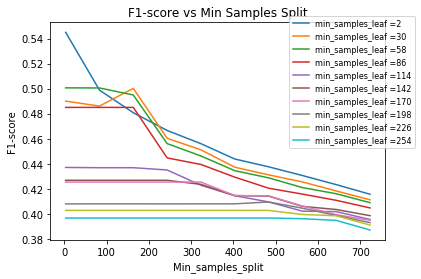

<Figure size 1080x576 with 0 Axes>

In [123]:
for i in min_samples_leaf_values:
    plt.plot(average_values['Min_Samples_Split'][average_values['Min_Samples_Leaf'] == i], average_values['f1_score'][average_values['Min_Samples_Leaf'] == i], label = "min_samples_leaf =" + str(i))
plt.legend(prop={'size': 8}, bbox_to_anchor=(1.1, 1.05))
plt.title("F1-score vs Min Samples Split")
plt.ylabel("F1-score")
plt.xlabel("Min_samples_split")
plt.figure(figsize=(15,8))
plt.show()

### Plus 2 Standard Deviation from Cross-Validation

In [137]:
std_deviation = plotting2.groupby(['Min_Samples_Split','Min_Samples_Leaf']).std().reset_index()

In [138]:
plus2std = plotting2.groupby(['Min_Samples_Split','Min_Samples_Leaf']).std().reset_index()

In [139]:
plus2std['f1_score'] = average_values['f1_score'] + 2*std_deviation['f1_score']

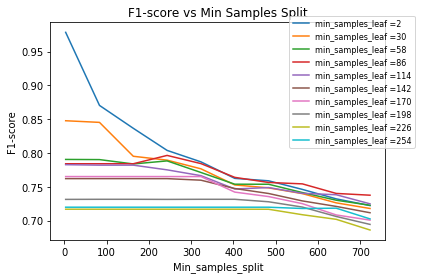

<Figure size 1080x576 with 0 Axes>

In [142]:
for i in min_samples_leaf_values:
    plt.plot(plus2std['Min_Samples_Split'][plus2std['Min_Samples_Leaf'] == i], plus2std['f1_score'][plus2std['Min_Samples_Leaf'] == i], label = "min_samples_leaf =" + str(i))
plt.legend(prop={'size': 8}, bbox_to_anchor=(1.1, 1.05))
plt.title("F1-score vs Min Samples Split")
plt.ylabel("F1-score")
plt.xlabel("Min_samples_split")
plt.figure(figsize=(15,8))
plt.show()

### Minus 2 Standard Deviation from Cross-Validation

In [140]:
minus2std = plotting2.groupby(['Min_Samples_Split','Min_Samples_Leaf']).std().reset_index()

In [141]:
minus2std['f1_score'] = average_values['f1_score'] - 2*std_deviation['f1_score']

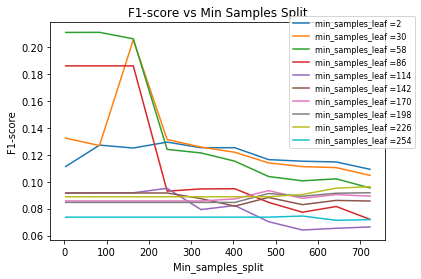

<Figure size 1080x576 with 0 Axes>

In [143]:
for i in min_samples_leaf_values:
    plt.plot(minus2std['Min_Samples_Split'][minus2std['Min_Samples_Leaf'] == i], minus2std['f1_score'][minus2std['Min_Samples_Leaf'] == i], label = "min_samples_leaf =" + str(i))
plt.legend(prop={'size': 8}, bbox_to_anchor=(1.1, 1.05))
plt.title("F1-score vs Min Samples Split")
plt.ylabel("F1-score")
plt.xlabel("Min_samples_split")
plt.figure(figsize=(15,8))
plt.show()

### Best hyperparameters: min_samples_split = 2,min_samples_leaf=1

In [177]:
dt2 = DecisionTreeClassifier(min_samples_split = 2,min_samples_leaf=1).fit(x_train_balanced, y_train_balanced)
y_pred = dt2.predict(x_test)
f1_score(y_test, y_pred, average = 'macro')

0.8649658121529221

In [178]:
data.columns

Index(['EVENT_ID', 'median_income', 'population_density',
       'housing_units_density', 'duration', 'weekend', 'sin_time', 'cos_time',
       'sin_date', 'cos_date', 'tornado_intensity', 'tornado_area',
       'average_range', 'minimum_range', 'average_latitude',
       'average_longitude', 'percent_land', 'multi_vortex',
       'multiclass_casualties'],
      dtype='object')

In [179]:
dt2.feature_importances_

array([0.0326485 , 0.02805201, 0.02876162, 0.04196103, 0.04715059,
       0.00792292, 0.03004925, 0.03604104, 0.03308052, 0.03491673,
       0.28507699, 0.15005165, 0.03600843, 0.10348764, 0.02703287,
       0.04439574, 0.03293405, 0.0004284 ])

### Random Forest Classifier

### Default Parameters

In [191]:
default_parameters = RandomForestClassifier().fit(x_train_balanced, y_train_balanced)
y_pred = default_parameters.predict(x_test)

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Confusion Matrix

In [192]:
array = confusion_matrix(y_test, y_pred)

In [193]:
[array[i]/sum(array[i]) for i in range(len(array))]

[array([0.95299778, 0.04515174, 0.00185048]),
 array([0.62121212, 0.35353535, 0.02525253]),
 array([0.18518519, 0.51851852, 0.2962963 ])]

F1 Score

In [194]:
f1_score(y_test, y_pred, average = 'macro')

0.5516372235435076

### Tuning on n_estimators and max_depth

In [198]:
estimators = [10,100,500,1000]
maxdepth = [2,4,6,8,10]

In [200]:
plotting_data = []
for i in estimators:
    for j in maxdepth:
        dt = RandomForestClassifier(n_estimators = i, max_depth = j).fit(x_train_balanced, y_train_balanced)
        y_pred = dt.predict(x_test)
        row = [i ,j, f1_score(y_test, y_pred, average = 'macro')]
        plotting_data.append(row)

In [212]:
pd.DataFrame(plotting_data)[pd.DataFrame(plotting_data)[2] == pd.DataFrame(plotting_data)[2].max()]

,0,1,2
19,1000,10,0.557811


### Best parameters: n_estimators = 1000, max_depth = 10

In [214]:
rfclf = RandomForestClassifier(n_estimators = 1000, max_depth = 10).fit(x_train_balanced, y_train_balanced)
y_pred = rfclf.predict(x_test)

In [215]:
f1_score(y_test, y_pred, average = 'macro')

0.560133809361273

In [216]:
array = confusion_matrix(y_test, y_pred)

In [218]:
array

array([[2435,  247,   20],
       [  81,  101,   16],
       [   1,   11,   15]])

In [217]:
[array[i]/sum(array[i]) for i in range(len(array))]

[array([0.90118431, 0.09141377, 0.00740192]),
 array([0.40909091, 0.51010101, 0.08080808]),
 array([0.03703704, 0.40740741, 0.55555556])]

## Multilayer Perceptron

In [224]:
MLP_clf = MLPClassifier().fit(x_train_balanced, y_train_balanced)
y_pred = MLP_clf.predict(x_test)

In [225]:
array = confusion_matrix(y_test, y_pred)

In [229]:
array

array([[2493,  200,    9],
       [ 130,   61,    7],
       [   9,   10,    8]])

In [227]:
f1_score(y_test, y_pred, average = 'macro')

0.5028705257321324

## Need to investigate how to use AUC for multi-class models

In [232]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in [0,1,2]:
# Need to fix script
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

ValueError: Can only tuple-index with a MultiIndex

Link: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html